In [4]:
import spark

editor = spark.GraphEditor()
if __name__ == "__main__":
    editor.launch()

ERROR:2025-10-20 13:24:59,020:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/nogar/Projects/Spark/.env_benchmarks/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/nogar/Projects/Spark/.env_benchmarks/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nogar/Projects/Spark/.env_benchmarks/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE
ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exce


INITIALIZING TopologicalLinearSpikerConfig

TopologicalLinearSpikerConfig
├── seed: int <- 954201685
├── dtype: DTypeLike <- <class 'numpy.float16'>
├── dt: float <- 1.0
├── tau: float <- 30.0
├── cd: float <- 2.0
├── max_freq: float <- 200.0
├── glue: jax.Array <- 0
├── mins: jax.Array <- -1
├── maxs: jax.Array <- 1
├── resolution: int <- 128
└── sigma: float <- 0.03125

INITIALIZING ALIFNeuronConfig
{'': {'config_delimiter__': '__', 'shared_config_delimiter__': '_s_', 'graph_editor_metadata__': {'inheritance_tree': {'main': {'seed': {'name': 'seed', 'type_string': 'int', 'inheritance_childs': [['soma_config', 'seed'], ['synapses_config', 'seed'], ['delays_config', 'seed'], ['learning_rule_config', 'seed']], 'break_inheritance': False, 'flags': 8}, 'dtype': {'name': 'dtype', 'type_string': 'DTypeLike', 'inheritance_childs': [['soma_config', 'dtype'], ['synapses_config', 'dtype'], ['delays_config', 'dtype'], ['learning_rule_config', 'dtype']], 'break_inheritance': False, 'flags': 8}, 

TypeError: 'PySide6.QtWidgets.QMessageBox.critical' called with wrong argument types:
  PySide6.QtWidgets.QMessageBox.critical(SparkGraphEditor, str, str)
Supported signatures:
  PySide6.QtWidgets.QMessageBox.critical(parent: PySide6.QtWidgets.QWidget | None, title: str, text: str, /, buttons: PySide6.QtWidgets.QMessageBox.StandardButton = Instance(QMessageBox.StandardButton.Ok), defaultButton: PySide6.QtWidgets.QMessageBox.StandardButton = Instance(QMessageBox.StandardButton.NoButton))

In [1]:
import spark
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

In [14]:
def step_current(
        t: float, # [ms]
        t_start: float, # [ms]
        t_end: float, # [ms]
        amplitude: float, # [nA] 
        dt: float=1.0 # [ms]
    ):
    assert t >= t_end and t_end > t_start and t_start >= 0
    assert dt > 0
    _t = int(round(t / dt)) + 1
    _t_start = int(round(t_start / dt))
    _t_end = int(round(t_end / dt))
    currents = np.zeros((_t,))
    currents[_t_start:_t_end] = amplitude
    times = np.linspace(0, t, len(currents))
    return times, currents

def _to_b2(times, currents):
    return b2.TimedArray(np.vstack([times, currents]), dt=b2.ms)

In [15]:
# Neuron model default values
V_REST = -70 * b2.mV
V_RESET = -65 * b2.mV
FIRING_THRESHOLD = -50 * b2.mV
MEMBRANE_RESISTANCE = 10. * b2.Mohm
MEMBRANE_TIME_SCALE = 8. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

def simulate_LIF_neuron(input_current,
                        simulation_time=5 * b2.ms,
                        v_rest=V_REST,
                        v_reset=V_RESET,
                        firing_threshold=FIRING_THRESHOLD,
                        membrane_resistance=MEMBRANE_RESISTANCE,
                        membrane_time_scale=MEMBRANE_TIME_SCALE,
                        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD):
    """
        Basic leaky integrate and fire neuron implementation.
    """
    # Leaky Integrate-and-Fire model
    eqs = """
    dv/dt =
    ( -(v-v_rest) + membrane_resistance * input_current(t,i) ) / membrane_time_scale : volt (unless refractory)"""
    neuron = b2.NeuronGroup(
        1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
        refractory=abs_refractory_period, method="linear")
    neuron.v = v_rest  # set initial value
    # monitoring membrane potential of neuron and injecting current
    state_monitor = b2.StateMonitor(neuron, ["v"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    # Simulation
    b2.run(simulation_time)
    return state_monitor, spike_monitor


In [16]:
times, currents = step_current(t=30, t_start=10, t_end=20, amplitude=0.5, dt=1)
times, currents

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ]))

In [17]:
times, currents = step_current(t=30, t_start=10, t_end=20, amplitude=0.5, dt=1)
b2_currents = _to_b2(times, currents)
#currents = b2.TimedArray(np.vstack([times, currents]), dt=b2.ms)


(state_monitor,spike_monitor) = simulate_LIF_neuron(input_current=b2_currents, simulation_time = 100 * b2.ms)

BrianObjectException: Error encountered with object named 'neurongroup_1'.
Object was created here (most recent call only, full details in debug log):
  File '/tmp/ipykernel_12171/4131051508.py', line 24, in simulate_LIF_neuron
    neuron = b2.NeuronGroup(

An error occurred when preparing an object. (See above for original error message and traceback.)

In [ ]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

def step_current(
        t: float, # [ms]
        t_start: float, # [ms]
        t_end: float, # [ms]
        amplitude: float, # [nA] 
        dt: float=1.0 # [ms]
    ):
    assert t >= t_end and t_end > t_start and t_start >= 0
    assert dt > 0
    _t = int(round(t / dt)) + 1
    _t_start = int(round(t_start / dt))
    _t_end = int(round(t_end / dt))
    currents = np.zeros((_t,))
    currents[_t_start:_t_end] = amplitude
    times = np.linspace(0, t, len(currents))
    return times, currents

def _to_b2(times, currents):
    return b2.TimedArray(np.vstack([times, currents]), dt=b2.ms)

# Neuron model default values
V_REST = -70 * b2.mV
V_RESET = -65 * b2.mV
FIRING_THRESHOLD = -50 * b2.mV
MEMBRANE_RESISTANCE = 10. * b2.Mohm
MEMBRANE_TIME_SCALE = 8. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

def simulate_LIF_neuron(input_current,
                        simulation_time=5 * b2.ms,
                        v_rest=V_REST,
                        v_reset=V_RESET,
                        firing_threshold=FIRING_THRESHOLD,
                        membrane_resistance=MEMBRANE_RESISTANCE,
                        membrane_time_scale=MEMBRANE_TIME_SCALE,
                        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD):
    """
        Basic leaky integrate and fire neuron implementation.
    """
    # Leaky Integrate-and-Fire model
    eqs = """
    dv/dt =
    ( -(v-v_rest) + membrane_resistance * input_current(t,i) ) / membrane_time_scale : volt (unless refractory)"""
    neuron = b2.NeuronGroup(
        1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
        refractory=abs_refractory_period, method="linear")
    neuron.v = v_rest  # set initial value
    # monitoring membrane potential of neuron and injecting current
    state_monitor = b2.StateMonitor(neuron, ["v"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    # Simulation
    b2.run(simulation_time)
    return state_monitor, spike_monitor


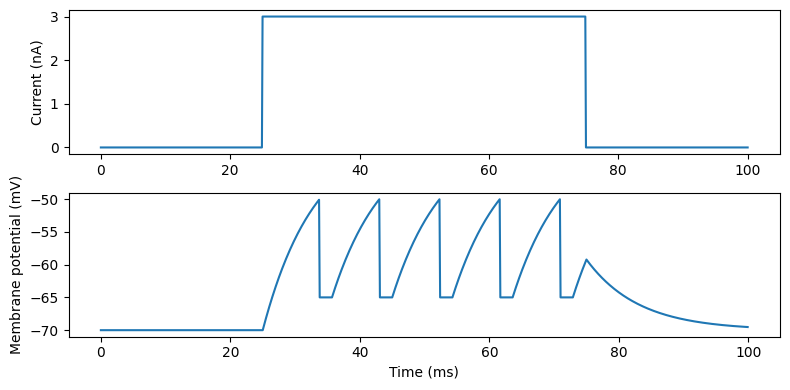

In [17]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt


def step_current(
        t: float, # [ms]
        t_start: float, # [ms]
        t_end: float, # [ms]
        amplitude: float, # [nA] 
        dt: float=1.0 # [ms]
    ):
    assert t >= t_end > t_start >= 0
    assert dt > 0
    _t = int(round(t / dt)) + 1
    _t_start = int(round(t_start / dt))
    _t_end = int(round(t_end / dt))
    currents = np.zeros((_t,))
    currents[_t_start:_t_end] = amplitude
    times = np.linspace(0, t, len(currents))
    return times, currents

# Neuron model default values
V_REST = -70 * b2.mV
V_RESET = -65 * b2.mV
FIRING_THRESHOLD = -50 * b2.mV
MEMBRANE_RESISTANCE = 10. * b2.Mohm
MEMBRANE_TIME_SCALE = 8. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

def simulate_LIF_neuron(
        times, 
        currents,
        v_rest=-70 * b2.mV,
        v_reset=-65 * b2.mV,
        firing_threshold=-50 * b2.mV,
        membrane_resistance=10. * b2.Mohm,
        membrane_time_scale=8. * b2.ms,
        abs_refractory_period=2.0 * b2.ms
        ):
    
    """
        Simulate a basic LIF neuron given an external current.
    """
    b2.start_scope()

    dt = times[1] - times[0]
    input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)

    eqs = """
    dv/dt = (-(v - v_rest) + membrane_resistance * input_current(t)) / membrane_time_scale : volt (unless refractory)
    """

    neuron = b2.NeuronGroup(
        N=1, 
        model=eqs, 
        reset="v=v_reset", 
        threshold="v>firing_threshold",
        refractory=abs_refractory_period, 
        method="linear"
    )
    neuron.v = v_rest

    state_monitor = b2.StateMonitor(neuron, "v", record=True)
    spike_monitor = b2.SpikeMonitor(neuron)

    b2.run(times[-1] * b2.ms)
    return state_monitor, spike_monitor


# ---- Example Usage ----
times, currents = step_current(100, 25, 75, amplitude=3.0, dt=0.1)
state_monitor, spike_monitor = simulate_LIF_neuron(times, currents)

plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.plot(times, currents)
plt.ylabel("Current (nA)")
plt.subplot(2, 1, 2)
plt.plot(state_monitor.t / b2.ms, state_monitor.v[0] / b2.mV)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.tight_layout()
plt.show()


In [3]:
import typing as tp

tp.get_type_hints(spark.nn.neurons.LIFNeuronConfig)

{'__config_delimiter__': str,
 '__shared_config_delimiter__': str,
 '__graph_editor_metadata__': dict,
 'seed': int,
 'dtype': typing.Union[str, type[typing.Any], numpy.dtype, jax._src.typing.SupportsDType],
 'dt': float,
 'units': tuple[int, ...],
 'max_delay': float,
 'inhibitory_rate': float,
 'async_spikes': bool,
 'soma_config': spark.nn.components.somas.leaky.LeakySomaConfig,
 'synapses_config': spark.nn.components.synapses.base.SynanpsesConfig,
 'delays_config': spark.nn.components.delays.base.DelaysConfig | None,
 'learning_rule_config': spark.nn.components.learning_rules.base.LearningRuleConfig | None}

In [21]:
a, b = [False,False,False,True,False], [1,2,3,4,5]

a.index(True)

3

In [18]:
raise TypeError(
    f'It is not possible to automatically resolve config initialization. ' \
    f'Only one SparkConfig class per field annotation can be used to allow for automatic initialization. ' \
    f'If this is inteded, define a default_factory or provide a SparkConfig to the parent initializer. '
)

TypeError: It is not possible to automatically resolve config initialization. Only one SparkConfig class per field annotation can be used to allow for automatic initialization. If this is inteded, define a default_factory or provide a SparkConfig to the parent initializer. 

In [12]:
field_type = (spark.nn.components.learning_rules.base.LearningRuleConfig, type(None))
[isinstance(t, type) and issubclass(t, spark.core.config.BaseSparkConfig) for t in field_type]

[True, False]

In [17]:
x = None
sum([True, False, True])

2

In [1]:
import jax

jax.devices()

[CudaDevice(id=0)]

[CudaDevice(id=0)]


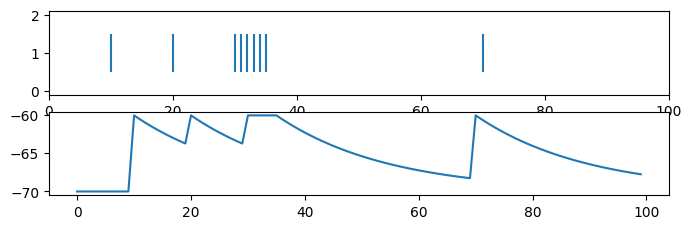

In [28]:
import jax
print(jax.devices())
import jax.numpy as jnp
import numpy as np
import spark
import matplotlib.pyplot as plt

@jax.jit
def run_model_split(graph, state, **inputs):
	model = spark.merge(graph, state)
	outputs = model(**inputs)
	_, state = spark.split((model))
	return outputs, state

synapses_config = spark.nn.synapses.LinearSynapsesConfig(
    units = (1,),
    async_spikes = False,
    kernel_initializer = spark.nn.initializers.ConstantInitializerConfig(scale=5000.0),
)
lif_neuron = spark.nn.neurons.LIFNeuron(
    _s_units = (1,),
    async_spikes = False,
    inhibitory_rate = 0.0,
    delays_config = None,
	synapses_config = synapses_config,
    learning_rule_config = None,
)
lif_neuron(in_spikes=spark.SpikeArray( jnp.zeros((1,)) ))




times, currents = step_current(100, 25, 75, amplitude=3.0, dt=0.1)
graph, state = spark.split((lif_neuron))

spike_times = [10, 20, 30, 31, 32, 33, 34, 35, 70]

spikes = np.zeros((100,))
spikes[np.array(spike_times)] = 1
outs = []
pots = []
for i in range(100):
    in_spikes = spark.SpikeArray( jnp.ones((1,)) * spikes[i] )
    outputs, state = run_model_split(graph, state, in_spikes=in_spikes)
    outs.append(np.array(outputs['out_spikes'].value))

    model = spark.merge(graph, state)
    pots.append(np.array(model.soma.potential.value) -70)

plt.figure(figsize=(8, 5))
plt.subplot(4, 1, 1)
plt.eventplot([t for t, s in enumerate(outs) if s == 1])
plt.xlim(0,100)
plt.subplot(4, 1, 2)
plt.plot(pots)
plt.show()

In [31]:
print(lif_neuron.config.summary())

LIFNeuronConfig
├── seed: int <- 3167083110
├── dtype: DTypeLike <- <class 'jax.numpy.float16'>
├── dt: float <- 1.0
├── units: tuple[int, ...] <- (1,)
├── max_delay: float <- 0.2
├── inhibitory_rate: float <- 0.0
├── async_spikes: bool <- False
├── LeakySomaConfig
│   ├── seed: int <- 1108403108
│   ├── dtype: DTypeLike <- <class 'jax.numpy.float16'>
│   ├── dt: float <- 1.0
│   ├── potential_rest: float | jax.Array <- -60.0
│   ├── potential_reset: float | jax.Array <- -50.0
│   ├── potential_tau: float | jax.Array <- 20.0
│   ├── resistance: float | jax.Array <- 100.0
│   └── threshold: float | jax.Array <- -40.0
├── LinearSynapsesConfig
│   ├── seed: int <- 2941567481
│   ├── dtype: DTypeLike <- <class 'jax.numpy.float16'>
│   ├── dt: float <- 1.0
│   ├── units: tuple[int, ...] <- (1,)
│   ├── async_spikes: bool <- False
│   └── ConstantInitializerConfig
│       ├── dtype: DTypeLike <- <class 'jax.numpy.float16'>
│       ├── scale: T <- 5000.0
│       ├── min_value: T | None <- Non

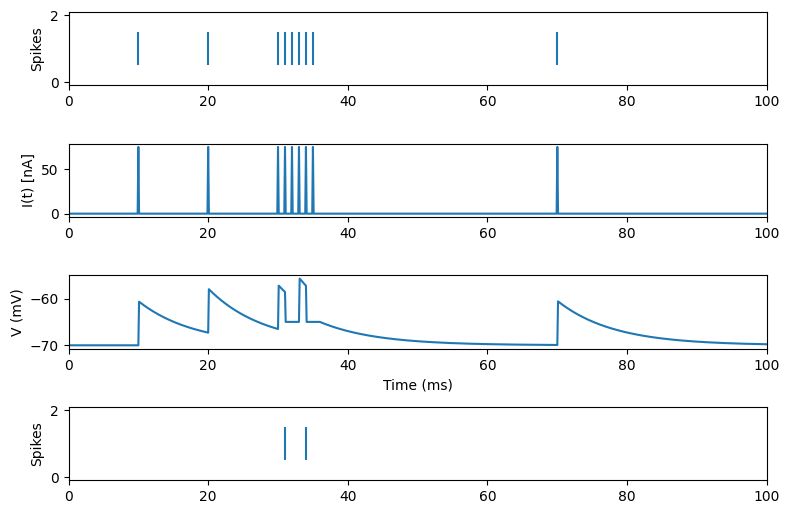

In [ ]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt


def spikes_to_current(spike_times, k=1.0, t_max=100.0, dt=0.1):
    """
    Convert spike times into a discrete current trace.
    Each spike contributes a single-step current of amplitude `k`.

    Parameters
    ----------
    spike_times : list or array
        Times (ms) when spikes occur.
    k : float
        Current amplitude per spike (arbitrary units).
    t_max : float
        Total simulation time (ms).
    dt : float
        Simulation time step (ms).

    Returns
    -------
    times : np.ndarray
        Time vector (ms)
    currents : np.ndarray
        Current trace (a.u.)
    """
    times = np.arange(0, t_max + dt, dt)
    currents = np.zeros_like(times)
    for s in spike_times:
        idx = int(round(s / dt))
        if 0 <= idx < len(currents):
            currents[idx] += k
    return times, currents


def simulate_LIF_from_spikes(
        spike_times,
        k=1.0,
        t_max=100.0,
        dt=0.1,
        v_rest=-70 * b2.mV,
        v_reset=-65 * b2.mV,
        firing_threshold=-50 * b2.mV,
        membrane_resistance=10. * b2.Mohm,
        membrane_time_scale=8. * b2.ms,
        abs_refractory_period=2.0 * b2.ms
    ):
    """
    Simulate a LIF neuron receiving discrete one-step current inputs from spikes.
    """
    b2.start_scope()

    # Build discrete current trace from spikes
    times, currents = spikes_to_current(spike_times, k=k, t_max=t_max, dt=dt)
    input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)

    eqs = """
    dv/dt = (-(v - v_rest) + membrane_resistance * input_current(t)) / membrane_time_scale : volt (unless refractory)
    """

    neuron = b2.NeuronGroup(
        1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
        refractory=abs_refractory_period, method="linear"
    )
    neuron.v = v_rest

    state_monitor = b2.StateMonitor(neuron, "v", record=True)
    spike_monitor = b2.SpikeMonitor(neuron)

    b2.run(t_max * b2.ms)
    return times, currents, state_monitor, spike_monitor


# Presynaptic spike times
spike_times = [10, 20, 30, 31, 32, 33, 34, 35, 70]

# Each spike produces one discrete current pulse (k = 2.0 nA)
times, currents, state_monitor, spike_monitor = simulate_LIF_from_spikes(
    spike_times, k=75.0, t_max=100.0
)

plt.figure(figsize=(8, 5))
plt.subplot(4, 1, 1)
plt.xlim(0,100)
plt.eventplot([spike_times])
plt.ylabel("Spikes")

plt.subplot(4, 1, 2)
plt.xlim(0,100)
plt.plot(times, currents)
plt.ylabel("I(t) [nA]")

plt.subplot(4, 1, 3)
plt.xlim(0,100)
plt.plot(state_monitor.t / b2.ms, state_monitor.v[0] / b2.mV)
plt.ylabel("V (mV)")
plt.xlabel("Time (ms)")
plt.tight_layout()

plt.subplot(4, 1, 4)
plt.xlim(0,100)
plt.eventplot([s / b2.ms for s in spike_monitor.t])
plt.ylabel("Spikes")
plt.show()


[31.0, 34.0]

<spikemonitor.t: array([31., 34.]) * msecond>

In [ ]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt


def linear_kernel(t, tau=5.0):
    """
    Simple linear decay kernel.
    Returns 0 for t < 0, otherwise max(1 - t/tau, 0).
    """
    return np.clip(1.0 - t / tau, 0.0, None)


def spikes_to_current(spike_times, kernel_func, t_max, dt=0.1, **kernel_kwargs):
    """
    Converts spike times (in ms) into a current trace using a custom kernel.

    Parameters
    ----------
    spike_times : array-like
        List or array of spike times [ms].
    kernel_func : callable
        Function(t, **kwargs) defining the kernel shape.
    t_max : float
        Total simulation time [ms].
    dt : float
        Time step [ms].
    kernel_kwargs : dict
        Additional parameters for kernel_func.

    Returns
    -------
    times : ndarray
        Time vector [ms].
    currents : ndarray
        Current trace [arbitrary units].
    """
    times = np.arange(0, t_max + dt, dt)
    currents = np.zeros_like(times)

    # Precompute kernel support
    t_kernel = np.arange(0, t_max, dt)
    kernel_vals = kernel_func(t_kernel, **kernel_kwargs)

    for s in spike_times:
        idx = int(round(s / dt))
        end = min(len(currents), idx + len(kernel_vals))
        k_end = end - idx
        currents[idx:end] += kernel_vals[:k_end]

    return times, currents


def simulate_LIF_from_spikes(spike_times,
                             kernel_func=linear_kernel,
                             kernel_kwargs=None,
                             t_max=100.0,
                             dt=0.1,
                             v_rest=-70 * b2.mV,
                             v_reset=-65 * b2.mV,
                             firing_threshold=-50 * b2.mV,
                             membrane_resistance=10. * b2.Mohm,
                             membrane_time_scale=8. * b2.ms,
                             abs_refractory_period=2.0 * b2.ms):
    """
    Simulates a single LIF neuron driven by spike-derived current.
    """
    b2.start_scope()
    if kernel_kwargs is None:
        kernel_kwargs = {}

    times, currents = spikes_to_current(spike_times, kernel_func, t_max, dt, **kernel_kwargs)
    input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)

    eqs = """
    dv/dt = (-(v - v_rest) + membrane_resistance * input_current(t)) / membrane_time_scale : volt (unless refractory)
    """

    neuron = b2.NeuronGroup(
        1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
        refractory=abs_refractory_period, method="linear")
    neuron.v = v_rest

    state_monitor = b2.StateMonitor(neuron, "v", record=True)
    spike_monitor = b2.SpikeMonitor(neuron)

    b2.run(t_max * b2.ms)
    return times, currents, state_monitor, spike_monitor


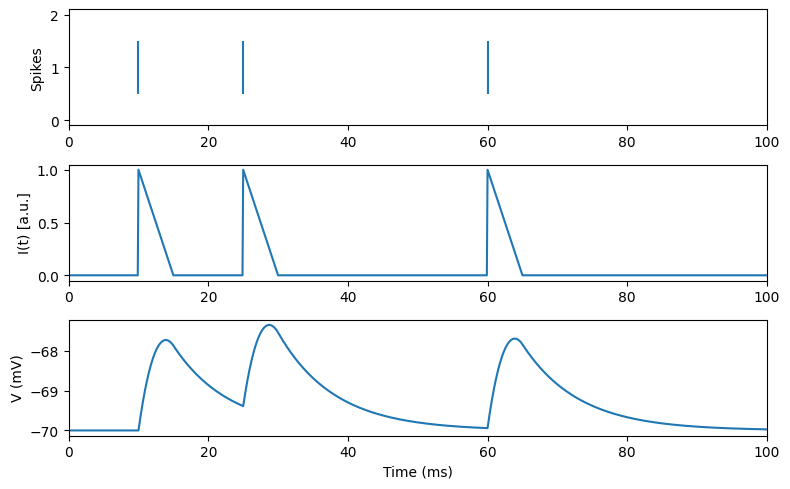

In [6]:
# Define presynaptic spikes at 10, 25, and 60 ms
spike_times = [10, 25, 60]

# Simulate neuron with a simple linear kernel (τ = 5 ms)
times, currents, state_monitor, spike_monitor = simulate_LIF_from_spikes(
    spike_times, kernel_func=linear_kernel, kernel_kwargs={'tau': 5.0}, t_max=100
)

# Plot results
plt.figure(figsize=(8, 5))
plt.subplot(3, 1, 1)
plt.eventplot([spike_times])
plt.xlim(0, 100)
plt.ylabel("Spikes")

plt.subplot(3, 1, 2)
plt.plot(times, currents)
plt.xlim(0, 100)
plt.ylabel("I(t) [a.u.]")

plt.subplot(3, 1, 3)
plt.plot(state_monitor.t / b2.ms, state_monitor.v[0] / b2.mV)
plt.xlim(0, 100)
plt.ylabel("V (mV)")
plt.xlabel("Time (ms)")
plt.tight_layout()
plt.show()
